# The post-blue straggler binary HS2220+2146

### First, let's load up packages, and data from MESA

In [2]:
import os
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.stats import norm
from scipy import optimize as opt
import emcee
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
from numpy.random import normal
import datetime
%matplotlib inline


# Import MESA lifetimes
datafile = os.path.abspath("../data/MESA_lifetime.dat")
names = ["name","lifetime"]
MESA_tcool = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)

# Move to log10 of stellar ages
MESA_tcool["lifetime"] = np.log10(MESA_tcool["lifetime"])

func_lifetime = interp1d(MESA_tcool["name"],pow(10.,MESA_tcool["lifetime"]), kind='linear', bounds_error=False, fill_value=1.0e7)
func_lifetime_inv = interp1d(pow(10.,MESA_tcool["lifetime"][::-1]),MESA_tcool["name"][::-1], kind='linear', bounds_error=False, fill_value = 0.45)

### Next, let's define an initial-final mass relation

In [3]:
# Import Andrews et al. (2016) IFMR study posteriors
datafile = os.path.abspath("../data/posterior_samples.txt")
names = ["b_perp","phi_1","phi_2","phi_3","mu","sigma"]
IFMR_posteriors = np.genfromtxt(datafile, dtype=None, usecols=(0,1,2,3,4,5), skip_header=1, names=names)

In [4]:
def IFMR_williams_inverse(M_wd):
    # M_f = 0.339+-0.015 + (0.129+-0.004)M_i
    return (M_wd - 0.339) / 0.129

def IFMR_williams(M_zams):
    # M_f = 0.339+-0.015 + (0.129+-0.004)M_i
    return 0.129 * M_zams + 0.339

def IFMR_andrews(M_zams_in):
    
    M_zams = np.array([M_zams_in])
    M_wd = np.array([])
    for p in IFMR_posteriors:
        M_wd = np.append(M_wd,get_m_wd(p, M_zams))
    
    return np.median(M_wd)

def IFMR_andrews_inverse(M_wd_in):
    
    M_wd = np.array([M_wd_in])
    M_zams = np.array([])
    for p in IFMR_posteriors:
        M_zams = np.append(M_zams,get_mzams(p, M_wd))
    
    return np.median(M_zams)





# Function to return M_zams from M_wd using model
def get_mzams(p, m_wd):
    bt1, th1, th2, th3, mu, sig = p
    
    # Get slopes from theta's
    m1 = np.tan(th1)
    m2 = np.tan(th2)
    m3 = np.tan(th3)
    
    # Determine b2, b3 as a function of other parameters
    b1 = bt1 / np.cos(th1)
    b2 = (m1-m2) * 2.0 + b1
    b3 = (m2-m3) * 4.0 + b2
    
    # Define array
    M_zams = np.array([])

    # Define piecewise linear model
    conds = [m_wd<=b1, (m_wd>b1) & (m_wd<=2.0*m1+b1), (m_wd>2.0*m1+b1) & (m_wd<=4.0*m2+b2), m_wd>4.0*m2+b2]
    funcs = [lambda m_wd: 0., lambda m_wd: 1./m1*(m_wd-b1), lambda m_wd: 1./m2*(m_wd-b2), lambda m_wd: 1./m3*(m_wd-b3)]

    M_zams = np.piecewise(m_wd, conds, funcs)
    
    return M_zams


# Function to return M_wd from M_zams using model
def get_m_wd(p, m_zams):
    bt1, th1, th2, th3, mu, sig = p
    
    # Get slopes from theta's
    m1 = np.tan(th1)
    m2 = np.tan(th2)
    m3 = np.tan(th3)
    
    # Determine b2, b3 as a function of other parameters
    b1 = bt1 / np.cos(th1)
    b2 = (m1-m2) * 2.0 + b1
    b3 = (m2-m3) * 4.0 + b2
    
    # Define array
    M_wd = np.array([])
    
    # Define piecewise linear model
    conds = [m_zams<=0.0, (m_zams>0.0) & (m_zams<=2.0), (m_zams>2.0) & (m_zams<=4.0), m_zams>4.0]
    funcs = [lambda m_zams: 0., lambda m_zams: m1*m_zams+b1, lambda m_zams: m2*m_zams+b2, lambda m_zams: m3*m_zams+b3]
    
    M_wd = np.piecewise(m_zams, conds, funcs)
    
    return M_wd    

### Now, we can add the data for the system at hand, HS 2220+2146

In [5]:
# Data from spectra
M_wd_A = 0.702
M_wd_A_err = 0.022
M_wd_B = 0.837
M_wd_B_err = 0.022

t_cool_A = 289.0
t_cool_A_err = 22.0
t_cool_B = 179.0
t_cool_B_err = 14.0

# Derived quantities
M_zams_A = IFMR_williams_inverse(M_wd_A)
M_zams_B = IFMR_williams_inverse(M_wd_B)

print "Initial mass of WD A (Williams IFMR): ", M_zams_A
print "Initial mass of WD B (Williams IFMR): ", M_zams_B

M_zams_A = IFMR_andrews_inverse(M_wd_A)
M_zams_B = IFMR_andrews_inverse(M_wd_B)

print "Initial mass of WD A (Andrews IFMR): ", M_zams_A
print "Initial mass of WD B (Andrews IFMR): ", M_zams_B



t_pre_wd_A = func_lifetime(M_zams_A)
t_pre_wd_B = func_lifetime(M_zams_B)

print "Pre-WD lifetime for WD A: ", t_pre_wd_A/1.0e6
print "Pre-WD lifetime for WD B: ", t_pre_wd_B/1.0e6

print "Total system age for WD A: ", t_pre_wd_A/1.0e6 + t_cool_A
print "Total system age for WD B: ", t_pre_wd_B/1.0e6 + t_cool_B

Initial mass of WD A (Williams IFMR):  2.81395348837
Initial mass of WD B (Williams IFMR):  3.86046511628
Initial mass of WD A (Andrews IFMR):  3.3259249721
Initial mass of WD B (Andrews IFMR):  4.47827194307
Pre-WD lifetime for WD A:  356.792001709
Pre-WD lifetime for WD B:  153.158133816
Total system age for WD A:  645.792001709
Total system age for WD B:  332.158133816


Clearly, the system ages are incompatible, even considering uncertainties on these measurements, and an uncertain IFMR. If we, however, consider the more massive WD as the result of the evolution of a blue straggler, then we can find the ages compatible. In this case, the less massive WD sets the age of the system at ~924 Myr. Let's see how this could work.

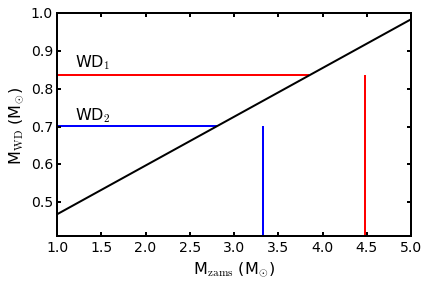

In [6]:
ran_M_i = np.linspace(0.1,10.0,100)
ran_M_f = IFMR_williams(ran_M_i)

plt.rcParams['axes.linewidth'] = 2.0
plt.rcParams['xtick.major.width'] = 2.0
plt.rcParams['ytick.major.width'] = 2.0
plt.rcParams['font.size'] = 14.0


plt.axhline(y=0.702, xmin=0, xmax=0.45, color='b', linewidth=2)
plt.axhline(y=0.837, xmin=0, xmax=0.71, color='r', linewidth=2)
plt.axvline(x=M_zams_A, ymin=0, ymax=0.49, color='b', linewidth=2)
plt.axvline(x=M_zams_B, ymin=0, ymax=0.72, color='r', linewidth=2)

plt.text(1.2, 0.86, r"WD$_1$", fontsize=16)
plt.text(1.2, 0.72, r"WD$_2$", fontsize=16)

plt.plot(ran_M_i, ran_M_f, color='k', linewidth=2)



plt.xlabel(r"M$_{\rm zams}$ (M$_{\odot}$)", fontsize=16.0)
plt.ylabel(r"M$_{\rm WD}$ (M$_{\odot}$)", fontsize=16.0)
plt.xlim(1.0,5.0)
plt.ylim(0.41,1.0)

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.12)

plt.savefig('../figures/M_zams.pdf')
#plt.show()

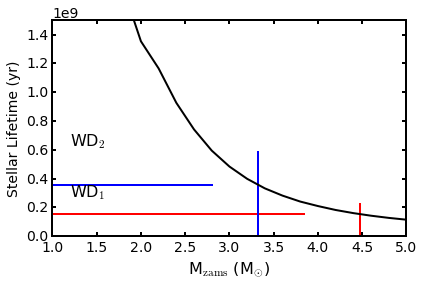

In [7]:
ran_time = func_lifetime(ran_M_i)



plt.axhline(y=t_pre_wd_A, xmin=0, xmax=0.45, linewidth=2, color='b')
plt.axhline(y=t_pre_wd_B, xmin=0, xmax=0.71, linewidth=2, color='r')
plt.axvline(x=M_zams_A, ymin=0, ymax=0.39, linewidth=2, color='b')
plt.axvline(x=M_zams_B, ymin=0, ymax=0.15, linewidth=2, color='r')

plt.text(1.2, 0.28e9, r"WD$_1$", fontsize=16)
plt.text(1.2, 0.63e9, r"WD$_2$", fontsize=16)


plt.plot(ran_M_i, ran_time, color='k', linewidth=2)


plt.xlabel(r"M$_{\rm zams}$ (M$_{\odot}$)", fontsize=16.0)
plt.ylabel("Stellar Lifetime (yr)")
plt.xlim(1.0, 5.0)
plt.ylim(0.0, 1.5e9)

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=0.12)

plt.savefig('../figures/M_lifetime.pdf')
#plt.show()

### Using the system age derived from WD A, we can determine the pre-WD lifetime for WD B

In [8]:
print "WD B pre-WD lifetime: ", t_pre_wd_A/1.0e6 + t_cool_A - t_cool_B

WD B pre-WD lifetime:  466.792001709


### Next, we can determine the pre-WD lifetime of a 3.86 Msun star

In [9]:
print "3.86 Msun star pre-WD lifetime: ", func_lifetime(3.86)/1.0e6
print "4.78 Msun star pre-WD lifetime: ", func_lifetime(4.78)/1.0e6

3.86 Msun star pre-WD lifetime:  231.104422148
4.78 Msun star pre-WD lifetime:  128.556486115


### Now we can determine how long it took for the inner binary to merge after its initial formation

In [10]:
print "Star B pre-merger time (Williams IFMR): ", t_pre_wd_A/1.0e6 + t_cool_A - t_cool_B - func_lifetime(3.86)/1.0e6
print "Star B pre-merger time (Andrews IFMR): ", t_pre_wd_A/1.0e6 + t_cool_A - t_cool_B - func_lifetime(4.78)/1.0e6

Star B pre-merger time (Williams IFMR):  235.687579562
Star B pre-merger time (Andrews IFMR):  338.235515594


In this theory, WD B, began as two separate stars of roughly 1.9 Msun each, then merged within 466 Myr, forming a 3.86 Msun star. After another ~100 Myr, Star A evolved into a WD, expanding the orbit. Another ~125 Myr later, Star B, the more massive in the pair evolved into a WD. We now see the system as a wide double white dwarf, some ~175 Myr after the system formed.

### Just to check, lets see how massive the stars in the inner binary could be such that they did not evolve into WDs in the first 4 Myrs

In [11]:
print "Mass of a star with a lifetime of 466 Myr: ", func_lifetime_inv(466.0*1.0e6)
print "Mass of a star with a lifetime of 466 Myr: ", func_lifetime_inv(338.0*1.0e6)

Mass of a star with a lifetime of 466 Myr:  3.04178339306
Mass of a star with a lifetime of 466 Myr:  3.38254570568


### Now, let's determine the projected angular separation of the binary

In [12]:
from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const

# Distance to pair
dist_wd_A = 79*u.pc
dist_wd_B = 73*u.pc

# Use average as the distance to the pair
dist_pair = (dist_wd_A + dist_wd_B) / 2.0

A_coor = coord.SkyCoord('22h23m01.74s', '+22d01m25.0s', distance=dist_pair)
B_coor = coord.SkyCoord('22h23m01.64s', '+22d01m31.0s', distance=dist_pair)

# Angular distance
theta = A_coor.separation(B_coor)

# Projected distance
sep_proj = A_coor.separation_3d(B_coor)

print "Angular separation: ", theta
print "Projected separation:", sep_proj.AU, "AU"

Angular separation:  0d00m06.159s
Projected separation: 468.085907421 AU


/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### Next, we can find the minimum orbital period, assuming a circular, face-on orbit

In [13]:
M_tot = (M_wd_A + M_wd_B)*u.solMass

P_orb = 2.0*np.pi * np.sqrt(sep_proj*sep_proj*sep_proj / (const.G * M_tot)).decompose()

print P_orb.to(u.yr)

8162.38084723 yr


In [14]:
print func_lifetime(1.93)/1.0e6
print func_lifetime(2.4)/1.0e6

1482.35369083
926.42730844


In [15]:
M_tot = (2.4 + 2.4)*u.solMass
P_orb = 7.0*u.day
A_temp = (((P_orb/(2.0*np.pi))**2 * (const.G * M_tot))**(1./3.)).decompose()

print A_temp.to(u.AU)



M_tot = (4.8 + 3.3)*u.solMass
P_orb = 10000.0*u.year
A_temp = (((P_orb/(2.0*np.pi))**2 * (const.G * M_tot))**(1./3.)).decompose()

print A_temp.to(u.AU)

0.120814876001 AU
932.244427529 AU


### Now, let's work backwards to estimate the separation of the outer binary when the inner binary merged

In [16]:
# Assuming Jeans mode mass loss

# A (M_1 + M_2) = const.

sep_proj_min = sep_proj * (M_wd_A + M_wd_B) / (M_zams_A + M_wd_B)
print "Minimum separation at merger:", sep_proj_min.AU, "AU"

# What was the orbital period at this time
M_tot_init = (M_zams_A + M_zams_B)*u.solMass
P_orb = 2.0*np.pi * np.sqrt(sep_proj_min*sep_proj_min*sep_proj_min / (const.G * M_tot_init)).decompose()
print "Orbital period at this time:", P_orb.to(u.yr)

# What about the orbital separation at birth
sep_proj_mid = sep_proj * (M_wd_A + M_wd_B) / (M_zams_A + M_zams_B)
print "Orbital separation at birth:", sep_proj_mid.AU, "AU"
M_tot_mid = (M_wd_A + M_zams_B)*u.solMass
P_orb_mid = 2.0*np.pi * np.sqrt(sep_proj_mid*sep_proj_mid*sep_proj_mid / (const.G * M_tot_init)).decompose()
print "Orbital period at this time:", P_orb_mid.to(u.yr)



Minimum separation at merger: 173.047608676 AU
Orbital period at this time: 814.764520709 yr
Orbital separation at birth: 92.3072827802 AU
Orbital period at this time: 317.422462381 yr


### We want to now calculate the merger product lifetime (from Glebbeek & Pols 2008)

In [17]:
M1 = 2.4
M2 = 2.4
t_merge = 338.0 * 1.0e6

# Load up some constants from their Table 3 (for Z = 0.02, 0.4-75 Msun)
c1 = -0.685213
c2 = 0.289269
c3 = 0.0123223
c4 = 3.3357e-6
c5 = 2.70964
c6 = 1.44963
c7 = 0.629121
c8 = 4.93117e-4

alpha = 1.67 # Mixing fraction parameter, adopted for Z = 0.02
q = M2 / M1 # Mass ratio

# Equation 3 from Glebbeek & Pols (2008)
# phi is the fraction of mass lost during merger
phi = 0.3 * q / ((1.0 + q)**2)

# Total mass of merger product
M_merger = (1.0 - phi) * (M1 + M2)

# Equation 8 from Glebbeek & Pols (2008)
# q_c is the fraction of hydrogen burned during the MS
def get_q_c(M):
    numerator = 1.0 + c1*M + c2*(M**3) + c3*(M**5) + c4*(M**7)
    denominator = c5 + c6*(M**2) + c7*(M**4) + c8*(M**6)
    return numerator/denominator

q_c_1 = get_q_c(M1)
q_c_2 = get_q_c(M2)
q_c_merger = get_q_c(M_merger)

# Equation 4 from Glebbeek & Pols (2008)
# Relative lifetimes of each star at merger
f1 = t_merge / func_lifetime(M1)
f2 = t_merge / func_lifetime(M2)


# Equation 4 from Glebbeek & Pols (2008)
f_app = (1.0 / (alpha * q_c_merger)) * (1.0 / (1.0 - phi)) * (q_c_1*f1 + q_c_2*f1*q)/(1.0+q)

print "The merger had a total mass of ", M_merger
print "The merger cause roughly ", phi*100.0, "% of the mass to be lost"
print "The merger product was already ", f_app*100.0, "% through its hydrogen burning phase"

print "The merger product has a pre-WD lifetime of ", func_lifetime(M_merger)/1.0e6
print "But it actually has a post-merger lifetime of", (1.0 - f_app)*func_lifetime(M_merger)/1.0e6

The merger had a total mass of  4.44
The merger cause roughly  7.5 % of the mass to be lost
The merger product was already  20.0243532749 % through its hydrogen burning phase
The merger product has a pre-WD lifetime of  156.606646349
But it actually has a post-merger lifetime of 125.247178232


### Let's determine the GR precession timescale

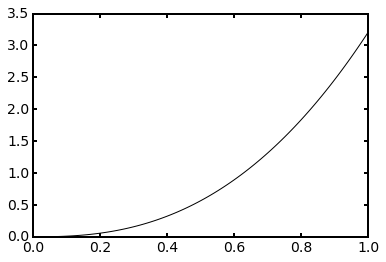

In [18]:
c = 2.998e10 # speed of light in cgs

def get_t_GR(M_1a, M_1b, A_1, ecc):
    return 2.0*np.pi * A_1**(2.5) * (const.c)**2 * (1.0 - ecc*ecc) / (3.0 * (const.G)**(1.5) * ((M_1a + M_1b)* u.solMass)**(1.5))

A_1 = np.linspace(0.01, 1.0, 100) * u.AU
t_GR = get_t_GR(2.4, 2.4, A_1, 0.0)

plt.plot(A_1, t_GR.to(u.yr) / 1.0e6, color='k')

plt.show()

### Now, let's determine the quadrupolar timescale of the original, hierarchical triple

In [19]:
A_1 = 1.0 * u.AU
A_2 = 90.0 * u.AU

def get_t_quad(A_1, A_2, ecc):
    t_quad = 2. * np.pi * (A_2**3) * (1-ecc**2)**(1.5) * np.sqrt(M_zams_B * u.solMass) / (A_1**(1.5) * (M_zams_A*u.solMass) * np.sqrt(const.G))
    return t_quad
    
print get_t_quad(A_1, A_2, 0.1).decompose().to(u.Myr)
#print t_quad.decompose().to(u.Myr)
P_orb_quad = 2.0*np.pi * np.sqrt(A_2**3 / (const.G * M_tot_init)).decompose()
print P_orb_quad.to(u.yr)

0.456847148896 Myr
305.595862541 yr


### Equate the GR precession timescale and the KL quadrupolar timescale to get a minimum A_1

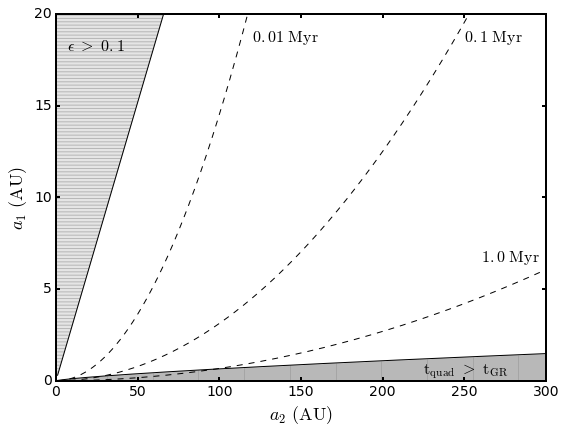

In [61]:
def get_min_A_GR(M_1, M_2, M_3, ecc_1, ecc_2, A_2):
    tmp_1 = 3.0 * A_2**3 * const.G / (const.c)**2
    tmp_2 = (1.0 - ecc_2**2)**(1.5) / (1.0 - ecc_1**2)
    tmp_3 = (M_1 + M_2)**2 / M_3 * u.solMass
    return (tmp_1 * tmp_2 * tmp_3)**(0.25)
    

def get_epsilon(A_1, A_2, ecc_2):
    return A_1 / A_2 * ecc_2 / (1.0 - ecc_2**2)

def get_a_1_from_epsilon(A_2, ecc_2, epsilon):
#    mass_term = 0.1
    mass_term = 1.0
    ecc_term = ecc_2 / (1.0 - ecc_2**2)
    return epsilon / mass_term * A_2 / ecc_term

def get_a_1_from_t_quad(A_2, ecc, t_quad):
    tmp_1 = 2. * np.pi * (A_2**3) * (1-ecc**2)**(1.5) * np.sqrt(M_zams_B * u.solMass) / (t_quad*1.0e6*u.yr * (M_zams_A*u.solMass) * np.sqrt(const.G))
    return tmp_1**(2.0/3.0)


#fig, (ax1, ax2)= plt.subplots(2, figsize=(8.0,8.0))
fig, (ax1)= plt.subplots(1, figsize=(8.0,6.0))


# Fiducial system parameters
M_1 = 2.4
M_2 = 2.4
M_3 = 3.3
ecc_1 = 0.0
ecc_2 = 0.3
t_merge = 350.0 # Myr
    
    
# Calculate minimum A_1 from t_quad < t_GR
A_2 = np.linspace(1.0, 300.0, 500) * u.AU
A_1 = get_min_A_GR(M_1, M_2, M_3, ecc_1, ecc_2, A_2)

A_1_val = A_1.to(u.AU).value
A_2_val = A_2.to(u.AU).value

for i in np.arange(len(A_2_val)-1):
    ax1.fill([A_2_val[i], A_2_val[i+1], A_2_val[i+1], A_2_val[i]],[0.0, 0.0, A_1_val[i+1], A_1_val[i+1]], color='k', alpha=0.1)

#ax1.text(10, 3.0, r"${\rm t}_{\rm quad}\ <\ {\rm t}_{\rm GR}$", size=16)
ax1.text(225, 0.4, r"${\rm t}_{\rm quad}\ >\ {\rm t}_{\rm GR}$", size=16)

ax1.plot(A_2_val, A_1_val, color='k', linestyle='solid')

ax1.set_xlabel(r'$a_2$ ${\rm (AU)}$', size=18)
ax1.set_ylabel(r'$a_1$ ${\rm (AU)}$', size=18)



#t_quad = 10.0 # Myr
#A_1 = get_a_1_from_t_quad(A_2, ecc_2, t_quad)
#ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='dashed')

#t_quad = 3.5 # Myr
#A_1 = get_a_1_from_t_quad(A_2, ecc_2, t_quad)
#ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='dashed')

t_quad = 1.0 # Myr
A_1 = get_a_1_from_t_quad(A_2, ecc_2, t_quad)
ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='dashed')

#t_quad = 0.5 # Myr
#A_1 = get_a_1_from_t_quad(A_2, ecc_2, t_quad)
#ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='dashed')

t_quad = 0.1 # Myr
A_1 = get_a_1_from_t_quad(A_2, ecc_2, t_quad)
ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='dashed')

t_quad = 0.01 # Myr
A_1 = get_a_1_from_t_quad(A_2, ecc_2, t_quad)
ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='dashed')


#ax1.set_ylim(0.0, 10.0)


#ax1.text(100.0, 28.5, r'${\rm t}_{\rm quad}\ =\ 0.01\ {\rm Myr}$', size=16)
#ax1.text(200.0, 28.5, r'${\rm t}_{\rm quad}\ =\ 0.1\ {\rm Myr}$', size=16)
#ax1.text(200.0, 6.5, r'${\rm t}_{\rm quad}\ =\ 1.0\ {\rm Myr}$', size=16)
ax1.text(120.0, 18.5, r'$0.01\ {\rm Myr}$', size=16)
ax1.text(250.0, 18.5, r'$0.1\ {\rm Myr}$', size=16)
ax1.text(260.0, 6.5, r'$1.0\ {\rm Myr}$', size=16)


epsilon = 0.1
A_1 = get_a_1_from_epsilon(A_2, ecc_2, epsilon)
ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='solid')

A_1_val = A_1.to(u.AU).value
A_2_val = A_2.to(u.AU).value

for i in np.arange(len(A_2_val)-1):
    ax1.fill([0.0, A_2_val[i], A_2_val[i+1], 0.0],[A_1_val[i], A_1_val[i], A_1_val[i+1], A_1_val[i+1]], color='k', alpha=0.1)


ax1.text(7.0, 18.0, r"$\epsilon\ >\ 0.1$", size=16)
    
# epsilon = 5.0e-4
# A_1 = get_a_1_from_epsilon(A_2, ecc_2, epsilon)
# ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='r', linestyle='dotted')

# epsilon = 1.0e-4
# A_1 = get_a_1_from_epsilon(A_2, ecc_2, epsilon)
# ax1.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='r', linestyle='dotted')


ax1.set_ylim(0.0,20.0)



# # Now get the quadrupolar timescale
# A_1 = get_min_A_GR(M_1, M_2, M_3, ecc_1, ecc_2, A_2)
# t_quad = get_t_quad(A_1, A_2, ecc_2)

# ymin = 1.0e-1
# ymax = 22.0

# ax2.plot(A_2, t_quad.to(u.yr) / 1.0e6, color='k')
# t_quad_val = t_quad.to(u.yr).value / 1.0e6

# for i in np.arange(len(A_2_val)-1):
#     ax2.fill([A_2_val[i], A_2_val[i+1], A_2_val[i+1], A_2_val[i]],[t_quad_val[i], t_quad_val[i], ymax, ymax], color='k', alpha=0.1)


# ax2.set_xlabel(r'$a_2$ ${\rm (AU)}$', size=16)
# ax2.set_ylabel(r'${\rm t}_{\rm quad}$ ${\rm (Myr)}$', size=16)

# ax2.axhline(t_merge/50.0, linestyle='--', color='k')
# ax2.text(7.0, t_merge/50.0+2.5, r'$\frac{1}{50}$ $t_{\rm merge}$', size=16)
# ax2.axhline(t_merge/100.0, linestyle='--', color='k')
# ax2.text(5.0, t_merge/100.0-1.3, r'$\frac{1}{100}$ $t_{\rm merge}$', size=16)
# ax2.axhline(t_merge/500.0, linestyle='--', color='k')
# ax2.text(5.0, t_merge/500.0-0.25, r'$\frac{1}{500}$ $t_{\rm merge}$', size=16)

# #ax2.text(150, 0.3, r"${\rm t}_{\rm quad}\ <\ {\rm t}_{\rm GR}$", size=16)

# ax2.set_ylim(ymin, ymax)

# fig.subplots_adjust(hspace=0.1)

# ax2.set_yscale('log')


plt.tight_layout()
#plt.gcf().subplots_adjust(bottom=0.08, left=0.08)
plt.subplots_adjust(left=0.10,bottom=0.10) 


#plt.show()
plt.savefig('../figures/KL_limits.pdf')






# # Now let's calculate epsilon as a function of A_2
# epsilon = get_epsilon(A_1.to(u.AU), A_2.to(u.AU), ecc_2)
# epsilon = get_epsilon(5.0, A_2.to(u.AU), ecc_2)

# a_1 = np.linspace(1.0, 10.0, 100)

# a_2 = 50.0
# epsilon = get_epsilon(a_1, a_2, ecc_2)
# plt.plot(a_1, epsilon, color='k', linestyle='solid', label=r'$a_2\ =\ 50\ {\rm AU}$')

# a_2 = 100.0
# epsilon = get_epsilon(a_1, a_2, ecc_2)
# plt.plot(a_1, epsilon, color='k', linestyle='dashed', label=r'$a_2\ =\ 100\ {\rm AU}$')

# a_2 = 200.0
# epsilon = get_epsilon(a_1, a_2, ecc_2)
# plt.plot(a_1, epsilon, color='k', linestyle='dotted', label=r'$a_2\ =\ 200\ {\rm AU}$')

# a_2 = 300.0
# epsilon = get_epsilon(a_1, a_2, ecc_2)
# plt.plot(a_1, epsilon, color='k', linestyle='dashdot', label=r'$a_2\ =\ 300\ {\rm AU}$')


# plt.legend(loc=2)


# plt.xlabel(r'$a_1$ ${\rm (AU)}$', size=16)
# plt.ylabel(r'$\epsilon$')

# plt.xlim(1.0, 10.0)
# plt.ylim(1.0e-3, 2.0e-2)

# plt.show()




# Now let's calculate t_quad as a function of A_1, A_2
# epsilon = get_epsilon(A_1.to(u.AU), A_2.to(u.AU), ecc_2)



# A_2 = np.linspace(1.0, 300.0, 500) * u.AU


# t_quad = 1.0 # Myr
# A_1 = get_a_1_from_t_quad(A_2, ecc_2, t_quad)
# plt.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='solid')

# t_quad = 0.5 # Myr
# A_1 = get_a_1_from_t_quad(A_2, ecc_2, t_quad)
# plt.plot(A_2.to(u.AU).value, A_1.to(u.AU).value, color='k', linestyle='dashed')



# #plt.legend(loc=2)


#ax1.set_xlabel(r'$a_2$ ${\rm (AU)}$', size=18)
# plt.ylabel(r'$a_1$ ${\rm (AU)}$', size=16)

# plt.ylim(0.1, 10.0)
# #plt.ylim(1.0e-3, 2.0e-2)

plt.show()






### Let's calculate the parameters of systems unstable to eccentric KL

In [ ]:
epsilon_crit = 0.01


def get_min_A(A_2, ecc):
    return epsilon_crit * A_2 * (1.0 - ecc*ecc) / ecc


A_2 = np.linspace(10.0, 500.0, 450) * u.AU

ecc = 0.1
A_1 = get_min_A(A_2, ecc)
t_quad = get_t_quad(A_1, A_2, ecc)
plt.plot(A_2, t_quad.to(u.yr) / 1.0e6, color='k')


ecc = 0.5
A_1 = get_min_A(A_2, ecc)
t_quad = get_t_quad(A_1, A_2, ecc)
plt.plot(A_2, t_quad.to(u.yr) / 1.0e6, color='k', linestyle='dashed')


ecc = 0.9
A_1 = get_min_A(A_2, ecc)
t_quad = get_t_quad(A_1, A_2, ecc)
plt.plot(A_2, t_quad.to(u.yr) / 1.0e6, color='k', linestyle='dotted')


ecc = 0.99
A_1 = get_min_A(A_2, ecc)
t_quad = get_t_quad(A_1, A_2, ecc)
plt.plot(A_2, t_quad.to(u.yr) / 1.0e6, color='k', linestyle='dashdot')


plt.xlabel(r'$A_2$ ${\rm (AU)}$', size=16)
plt.ylabel(r'$t_{\rm quad}$ ${\rm (Myr)}$', size=16)
plt.yscale('log')


plt.show()


In [ ]:
t_merge = 350.0 # Myr

xmin = 0.0
xmax = 600.0
ymin = 1.0e-2
ymax = 1.0e5

ran_A = np.linspace(10.0, 450.0, 100) * u.AU
ecc = 0.1

A_1 = 0.01 * u.AU
ran_t = get_t_quad(A_1, ran_A, 0.1)
plt.plot(ran_A, ran_t.to(u.yr)/1.0e6, color='k')
plt.text(350.0, 1.0e4, r'$A_1 =\ 0.01\ {\rm AU}$')

A_1 = 0.1 * u.AU
ran_t = get_t_quad(A_1, ran_A, 0.1)
plt.plot(ran_A, ran_t.to(u.yr)/1.0e6, color='k')
plt.text(350.0, 3.0e2, r'$A_1 =\ 0.1\ {\rm AU}$')

A_1 = 1.0 * u.AU
ran_t = get_t_quad(A_1, ran_A, 0.1)
plt.plot(ran_A, ran_t.to(u.yr)/1.0e6, color='k')
plt.text(350.0, 10.0e0, r'$A_1 =\ 1\ {\rm AU}$')


# To mark off 1/5th and 1/100th of the calculated merger time of 475 Myr
plt.axhline(t_merge/5.0, linestyle='--', color='k')
plt.axhline(t_merge/100.0, linestyle='--', color='k')
plt.text(500.0, t_merge/5.0+75.0, r'$\frac{1}{5}$ $t_{\rm merge}$', size=16)
plt.text(490.0, 0.9, r'$\frac{1}{100}$ $t_{\rm merge}$', size=16)
plt.fill([xmin, xmax, xmax, xmin],[t_merge/100.0, t_merge/100.0, t_merge/5.0, t_merge/5.0], color='k', alpha=0.1)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel(r'$A_2$ ${\rm (AU)}$', size=16)
plt.ylabel(r'$t_{\rm quad}$ ${\rm (Myr)}$', size=16)
plt.yscale('log')

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.13, left=0.12)

plt.savefig('../figures/t_quad.pdf')
#plt.show()

### Let's load up the FLWO observations

In [123]:
# Import MESA lifetimes
datafile_A = os.path.abspath("../data/FLWO_A.dat")
datafile_B = os.path.abspath("../data/FLWO_B.dat")
names = ["time","rv","rv_err"]
FLWO_A = np.genfromtxt(datafile_A, dtype=None, usecols=(0,1,2), names=names)
FLWO_B = np.genfromtxt(datafile_B, dtype=None, usecols=(0,1,2), names=names)

# Adjust time to Julian Date
FLWO_A["time"] = FLWO_A["time"] + 2450000.0
FLWO_B["time"] = FLWO_B["time"] + 2450000.0

### Get radial velocities for the Gemini and VLT spectra

In [116]:
names = ["wavelength","flux"]

# Import SEDs
datafile = os.path.abspath("../SED/HS2220+2146A_SED")
SED_A = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)

datafile = os.path.abspath("../SED/HS2220+2146B_SED")
SED_B = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)

# Import Gemini spectra
datafile = os.path.abspath("../spectra/GMOS/HS2220_1_A.dat")
GMOS_A_1 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)
datafile = os.path.abspath("../spectra/GMOS/HS2220_1_B.dat")
GMOS_B_1 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)

datafile = os.path.abspath("../spectra/GMOS/HS2220_2_A.dat")
GMOS_A_2 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)
datafile = os.path.abspath("../spectra/GMOS/HS2220_2_B.dat")
GMOS_B_2 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)

datafile = os.path.abspath("../spectra/GMOS/HS2220_3_A.dat")
GMOS_A_3 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)
datafile = os.path.abspath("../spectra/GMOS/HS2220_3_B.dat")
GMOS_B_3 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)

# Import VLT spectra
datafile = os.path.abspath("../spectra/HS2220_a.dat")
VLT_A_1 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)
datafile = os.path.abspath("../spectra/HS2220_b.dat")
VLT_A_2 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)

datafile = os.path.abspath("../spectra/HS2220b_a.dat")
VLT_B_1 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)
datafile = os.path.abspath("../spectra/HS2220b_b.dat")
VLT_B_2 = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)

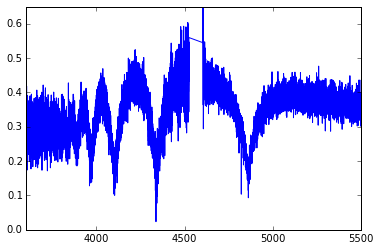

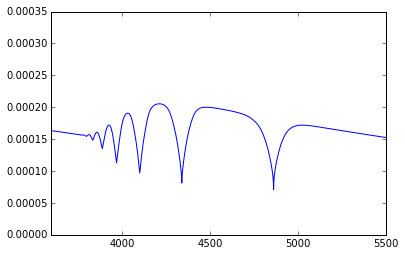

In [117]:
# Take a look at spectra

plt.plot(VLT_A_1["wavelength"], VLT_A_1["flux"])

plt.xlim(3600.0, 5500.0)
plt.ylim(0.0, 0.65)

plt.show()


plt.plot(SED_B["wavelength"], SED_B["flux"])

plt.xlim(3600.0, 5500.0)

plt.show()

In [118]:
# Define the objective function

# Only use 30 angstroms around each Balmer line.
lambda_width = 30.0

# Central wavelengths
lambda_zero = [4861.33, 4340.47, 4101.74, 3970.07, 3889.05]

# Signal-noise ratio
sd = 1.0/50.0

# Calculate Doppler shift
def doppler_shift(lambs, vel):
    freq = 3.0e18 / lambs
    freq_out = (1.0 - vel / 3.0e5) * freq
    lamb_out = 3.0e18 / freq_out
    return lamb_out

# Objective function
def obj_func(p, SED_lambs, SED_flux, spec_lambs, spec_flux, sd):
#def obj_func(SED_lambs, SED_flux, spec_lambs, spec_flux, snr, rv, C1, C2, C3, C4, C5):
    rv, C1, C2, C3, C4, C5, th1, th2, th3, th4, th5 = p
    C_flux = np.array([C1, C2, C3, C4, C5])
    thetas = np.array([th1, th2, th3, th4, th5])
    func_flux = interp1d(doppler_shift(SED_lambs, rv), SED_flux)
    
    prob = np.array([])
    for i in np.arange(5):
        line_lambs = spec_lambs[np.where(abs(spec_lambs - lambda_zero[i]) < lambda_width)]
        line_flux = spec_flux[np.where(abs(spec_lambs - lambda_zero[i]) < lambda_width)]
        line_SED_flux = C_flux[i] * func_flux(line_lambs)  + C_flux[i] * func_flux(lambda_zero[i]) * (line_lambs - lambda_zero[i]) / lambda_width * np.tan(thetas[i])
#        sd = line_flux / snr
        
        diff = -(line_flux - line_SED_flux)*(line_flux - line_SED_flux) / (2.0 * sd*sd)
        prob = np.append(prob, diff)

    return prob


def sd_calc(p, SED_lambs, SED_flux, spec_lambs, spec_flux):
    rv, C1, C2, C3, C4, C5, th1, th2, th3, th4, th5 = p
    C_flux = np.array([C1, C2, C3, C4, C5])
    thetas = np.array([th1, th2, th3, th4, th5])
    func_flux = interp1d(doppler_shift(SED_lambs, rv), SED_flux)

    prob = np.array([])
    for i in np.arange(5):
        line_lambs = spec_lambs[np.where(abs(spec_lambs - lambda_zero[i]) < lambda_width)]
        line_flux = spec_flux[np.where(abs(spec_lambs - lambda_zero[i]) < lambda_width)]
        line_SED_flux = C_flux[i] * func_flux(line_lambs)  + C_flux[i] * func_flux(lambda_zero[i]) * (line_lambs - lambda_zero[i]) / lambda_width * np.tan(thetas[i])

        diff = (line_flux - line_SED_flux)*(line_flux - line_SED_flux)
        prob = np.append(prob, diff)

    sd = np.sqrt(1.0/(len(line_lambs)-1.0) * np.sum(prob))
    
    return sd


### Prior, posterior, and wrapper function

In [119]:
# This function runs emcee
def run_inference(SED_lambs, SED_flux, spec_lambs, spec_flux, sd, p_i, nwalkers=32, nburn=500, nsteps=1000):
    # number of parameters
    ndim = 11

    # initial positions for walkers
    p0 = np.zeros((nwalkers,ndim))
    p0[:,0] = np.random.normal(p_i[0], 0.1, size=nwalkers) # rv
    p0[:,1] = np.random.normal(p_i[1], 0.03*p_i[1], size=nwalkers) # C1
    p0[:,2] = np.random.normal(p_i[2], 0.03*p_i[2], size=nwalkers) # C2
    p0[:,3] = np.random.normal(p_i[3], 0.03*p_i[3], size=nwalkers) # C3
    p0[:,4] = np.random.normal(p_i[4], 0.03*p_i[4], size=nwalkers) # C4
    p0[:,5] = np.random.normal(p_i[5], 0.03*p_i[5], size=nwalkers) # C5
    p0[:,6] = np.random.normal(p_i[6], 0.03, size=nwalkers) # th1
    p0[:,7] = np.random.normal(p_i[7], 0.03, size=nwalkers) # th2
    p0[:,8] = np.random.normal(p_i[8], 0.03, size=nwalkers) # th3
    p0[:,9] = np.random.normal(p_i[9], 0.03, size=nwalkers) # th4
    p0[:,10] = np.random.normal(p_i[10], 0.03, size=nwalkers) # th5

    
    temp = 0.0
    args = (SED_lambs, SED_flux, spec_lambs, spec_flux, sd)
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=args)

    # burn-in
    sampler.run_mcmc(p0, N=nburn)
    pos,prob,state = sampler.run_mcmc(p0, N=nburn)

    # Determine S/N ratio
    sd = sn_ratio(sampler.flatchain[-1], SED_lambs, SED_flux, spec_lambs, spec_flux)
    args = (SED_lambs, SED_flux, spec_lambs, spec_flux, sd)
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=args)
    print "Standard deviation:", sd
    
    # throw out burn-in samples
    sampler.reset() 
    pos,prob,state = sampler.run_mcmc(pos, N=nsteps)

    
    return sampler



def ln_posterior(p, SED_lambs, SED_flux, spec_lambs, spec_flux, sd):

    # Check prior on model first
    lp = ln_prior(p)
    
    if np.any(np.isnan(lp)):
        return -np.inf

    # Then check likelihood of parameters
    ll = obj_func(p, SED_lambs, SED_flux, spec_lambs, spec_flux, sd)
    
    if np.any(np.isnan(ll) | np.isinf(ll)):
        return -np.inf
    
    if np.all(ll == 0.):
        return -np.inf
    
    return lp + ll.sum()



def ln_prior(p):
    rv, C1, C2, C3, C4, C5, th1, th2, th3, th4, th5 = p

    if rv < -1000.0 or rv > 1000.0:
        return -np.inf
    
    if C1 < 0.0 or C2 < 0.0 or C3 < 0.0 or C4 < 0.0 or C5 < 0.0:
        return -np.inf
    
    if th1 < -np.pi/2.0 or th1 > np.pi/2.0:
        return -np.inf
    if th2 < -np.pi/2.0 or th2 > np.pi/2.0:
        return -np.inf
    if th3 < -np.pi/2.0 or th3 > np.pi/2.0:
        return -np.inf
    if th4 < -np.pi/2.0 or th4 > np.pi/2.0:
        return -np.inf
    if th5 < -np.pi/2.0 or th5 > np.pi/2.0:
        return -np.inf
    
    return 0.0


In [120]:
radial_velocity = 1.0

# For Gemini/GMOS spectra
#C1 = 6.6e8
#C2 = 4.3e8
#C3 = 2.9e8
#C4 = 2.0e8
#C5 = 1.6e8

# For VLT spectra
C1 = 3.0e3
C2 = 3.0e3
C3 = 3.0e3
C4 = 3.0e3
C5 = 3.0e3

# No slope to subtract continuum
th1 = 0.0
th2 = 0.0
th3 = 0.0
th4 = 0.0
th5 = 0.0

p_start = radial_velocity, C1, C2, C3, C4, C5, th1, th2, th3, th4, th5

In [121]:
# To restart simulation from last element in last Markov chain
#p_start = sampler_A_1.flatchain[-1]
#print p_start

# VLT Spectra
sampler_A_1 = run_inference(SED_A["wavelength"], SED_A["flux"], VLT_A_1["wavelength"], VLT_A_1["flux"], sd, p_start, nburn=3000, nsteps=1000)
sampler_A_2 = run_inference(SED_A["wavelength"], SED_A["flux"], VLT_A_2["wavelength"], VLT_A_2["flux"], sd, p_start, nburn=3000, nsteps=1000)
sampler_B_1 = run_inference(SED_B["wavelength"], SED_B["flux"], VLT_B_1["wavelength"], VLT_B_1["flux"], sd, p_start, nburn=3000, nsteps=1000)
sampler_B_2 = run_inference(SED_B["wavelength"], SED_B["flux"], VLT_B_2["wavelength"], VLT_B_2["flux"], sd, p_start, nburn=3000, nsteps=1000)

# Gemini Spectra
#sampler_A_1 = run_inference(SED_B["wavelength"], SED_B["flux"], GMOS_A_1["wavelength"], GMOS_A_1["flux"], snr, p_start, nburn=1000, nsteps=1000)
#sampler_A_2 = run_inference(SED_B["wavelength"], SED_B["flux"], GMOS_A_2["wavelength"], GMOS_A_2["flux"], snr, p_start, nburn=2000, nsteps=1000)
#sampler_A_3 = run_inference(SED_B["wavelength"], SED_B["flux"], GMOS_A_3["wavelength"], GMOS_A_3["flux"], snr, p_start, nburn=2000, nsteps=1000)

#sampler_B_1 = run_inference(SED_A["wavelength"], SED_A["flux"], GMOS_B_1["wavelength"], GMOS_B_1["flux"], snr, p_start, nburn=2000, nsteps=1000)
#sampler_B_2 = run_inference(SED_A["wavelength"], SED_A["flux"], GMOS_B_2["wavelength"], GMOS_B_2["flux"], snr, p_start, nburn=2000, nsteps=1000)
#sampler_B_3 = run_inference(SED_A["wavelength"], SED_A["flux"], GMOS_B_3["wavelength"], GMOS_B_3["flux"], snr, p_start, nburn=2000, nsteps=1000)


NameError: global name 'sn_ratio' is not defined

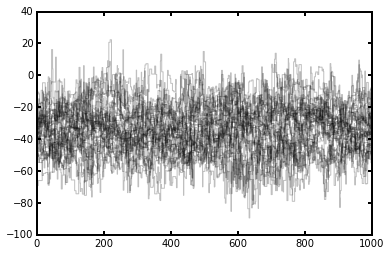

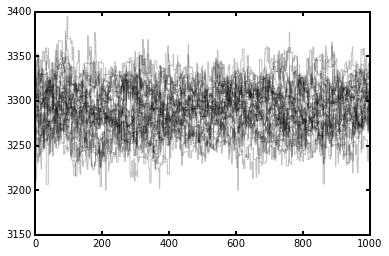

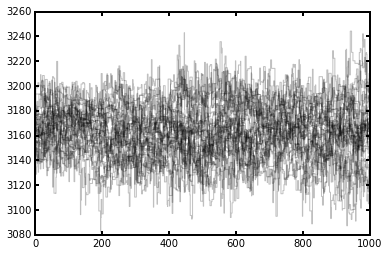

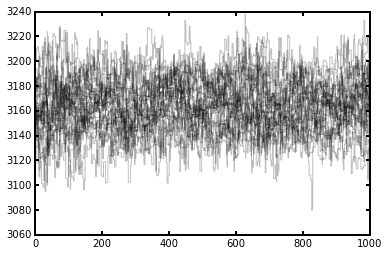

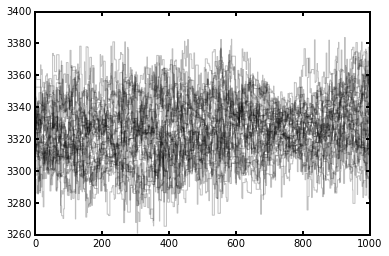

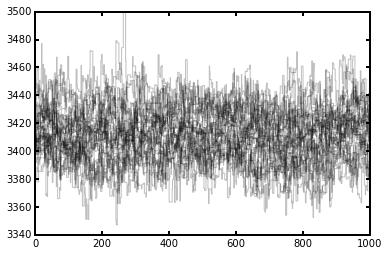

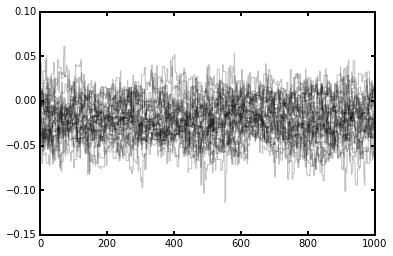

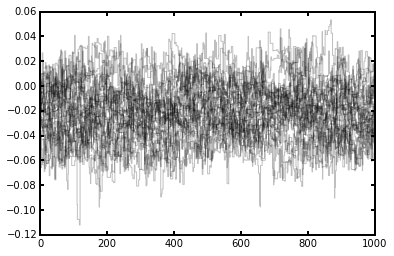

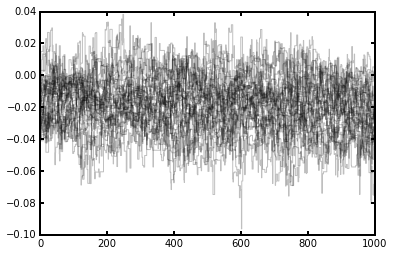

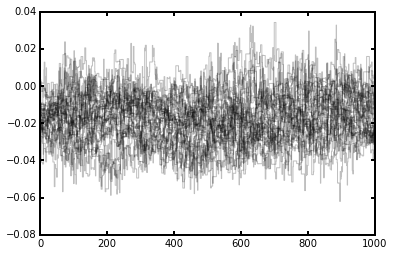

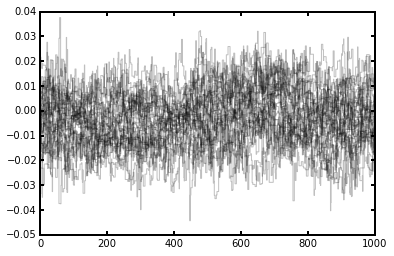

In [437]:
for i in range(sampler_B_2.dim):
    plt.figure()
    for chain in sampler_B_2.chain[...,i]:
        plt.plot(chain, alpha=0.25, color='k', drawstyle='steps')

[ -2.66520995e+01   3.31025217e+03   3.14307479e+03   3.16329272e+03
   3.31397856e+03   3.42972170e+03  -2.00762639e-02  -1.52759474e-02
  -3.94821219e-02   4.17165900e-03  -7.85976222e-03]


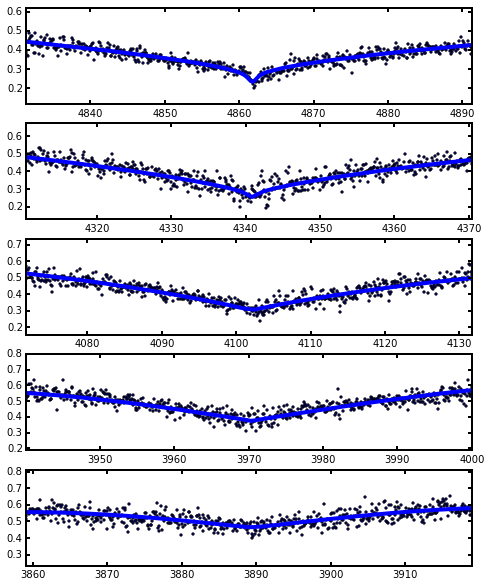

In [441]:
plt.figure(figsize=(8, 10))


p_out = sampler_B_2.flatchain[-1]
#p_out = radial_velocity, C1, C2, C3, C4, C5, th1-0.1, th2, th3, th4, th5
print p_out

func_flux = interp1d(doppler_shift(SED_B["wavelength"], p_out[0]), SED_B["flux"])

for i in np.arange(5):
    plt.subplot(5,1,i+1)

    tmp_lamb = np.linspace(lambda_zero[i]-lambda_width, lambda_zero[i]+lambda_width, 1000)
#    tmp_flux = p_out[i+1] * func_flux(tmp_lamb)
#    tmp_flux = p_out[i+1] * func_flux(tmp_lamb) * (tmp_lamb - lambda_zero[i]) * np.tan(p_out[i+6])
    tmp_flux = p_out[i+1] * func_flux(tmp_lamb) + p_out[i+1] * func_flux(lambda_zero[i]) * (tmp_lamb - lambda_zero[i]) / lambda_width * np.tan(p_out[i+6])

    
    plt.plot(tmp_lamb, tmp_flux, linewidth=4)
    plt.scatter(VLT_B_2["wavelength"], VLT_B_2["flux"], marker='.')

    plt.xlim(lambda_zero[i]-lambda_width,lambda_zero[i]+lambda_width)
    plt.ylim(0.5 * min(tmp_flux), 1.4 * max(tmp_flux) )




plt.show()

Mean = -34.0223708534
Standard Deviation = 14.439461288


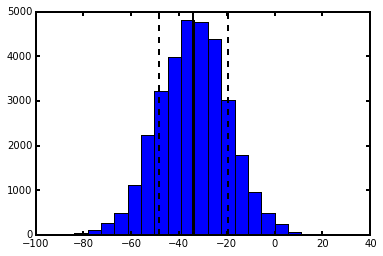

In [464]:
sampler = sampler_B_2

plt.hist(sampler.flatchain.T[0], 20)

mean = np.mean(sampler.flatchain.T[0])
std_dev = np.std(sampler.flatchain.T[0])

plt.axvline(mean, color='k', linewidth=2)
plt.axvline(mean-std_dev, color='k', linewidth=2, linestyle="--")
plt.axvline(mean+std_dev, color='k', linewidth=2, linestyle="--")

print "Mean =", mean
print "Standard Deviation =", std_dev

plt.show()

In [488]:
VLT_A = np.array([])

time = 2452542.57046103617
mean = -np.mean(sampler_A_1.flatchain.T[0])
std_dev = np.std(sampler_A_1.flatchain.T[0])
VLT_A = np.append(VLT_A, (time, mean, std_dev))

time = 2452543.63489676593
mean = -np.mean(sampler_A_2.flatchain.T[0])
std_dev = np.std(sampler_A_2.flatchain.T[0])
VLT_A = np.vstack((VLT_A, (time, mean, std_dev)))

VLT_A = VLT_A.T


VLT_B = np.array([])
time = 2452542.57601094618
mean = -np.mean(sampler_B_1.flatchain.T[0])
std_dev = np.std(sampler_B_1.flatchain.T[0])
VLT_B = np.append(VLT_B, (time, mean, std_dev))

time = 2452543.62993631605
mean = -np.mean(sampler_B_2.flatchain.T[0])
std_dev = np.std(sampler_B_2.flatchain.T[0])
VLT_B = np.vstack((VLT_B, (time, mean, std_dev)))

VLT_B = VLT_B.T


print VLT_A[1]
print VLT_B[1]

[ 31.3633724   30.28021225]
[ 40.35039108  34.02237085]


In [167]:
from astropy.time import Time

WD_A_time = Time(FLWO_A["time"], format="jd")

obs4_date = Time(2457311.0, format="jd")

dt = WD_A_time - obs4_date
print dt.sec / 3600.0


[-2282.843424   -2282.553408   -2282.28144    -2067.006096   -2066.771088
 -2066.528016   -2066.293272   -2066.057976     -30.148464     -29.913744
   -29.68154399   -29.44932      -29.217408      16.142256      16.377264
    16.622784      16.86444       17.104152  ]


37.1527434398 25.278487422 55.6530728258 23.2895088466


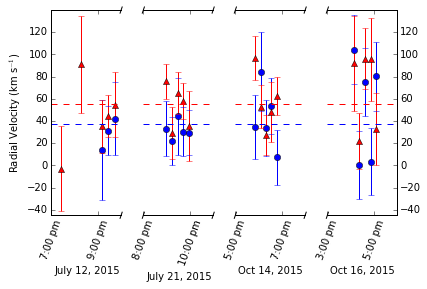

In [185]:
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)
ax4 = fig.add_subplot(1,4,4)
#f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharey=True)



#plt.xticks(rotation=70)


# # Sept 25th
# ax1.errorbar((VLT_A[0] - 2452542.0)*24.0 - 12.0, VLT_A[1], yerr=VLT_A[2], fmt='o', color='b')
# ax1.errorbar((VLT_B[0] - 2452542.0)*24.0 - 12.0, VLT_B[1], yerr=VLT_B[2], fmt='o', color='r')
# ax1.set_xlim(0.0, 6.0)
# ax1.set_xticks(np.arange(1.0,7.0, 2.0))
# ax1.set_ylim(-40.0,140.0)
# ax1.yaxis.tick_left()

# new_ticks = np.array([])
# tick = ax1.get_xticks().tolist()
# for a in tick:
#     a = str(int(a))+':00 pm'
#     new_ticks = np.append(new_ticks, a)

# ax1.set_xticklabels(new_ticks, rotation=70)




# # Sept 26th
# ax2.errorbar((VLT_A[0] - 2452543.0)*24.0 - 12.0, VLT_A[1], yerr=VLT_A[2], fmt='o', color='b')
# ax2.errorbar((VLT_B[0] - 2452543.0)*24.0 - 12.0, VLT_B[1], yerr=VLT_B[2], fmt='o', color='r')
# ax2.set_xlim(0.0, 6.0)
# ax2.set_xticks(np.arange(1.0,7.0, 2.0))
# ax2.set_ylim(-40.0,140.0)
# ax2.set_yticks([])
# ax2.yaxis.tick_left()
# #ax2.set_yticks([])

# new_ticks = np.array([])
# tick = ax2.get_xticks().tolist()
# for a in tick:
#     a = str(int(a))+':00 pm'
#     new_ticks = np.append(new_ticks, a)

# ax2.set_xticklabels(new_ticks, rotation=70)
# ax2.set_yticklabels([])






# July 12th
obs1_date = Time(2457215.0, format="jd")
obs1_A_time = np.array((Time(FLWO_A["time"], format="jd") - obs1_date).sec / 3600.0)
obs1_B_time = np.array((Time(FLWO_B["time"], format="jd") - obs1_date).sec / 3600.0)
ax1.errorbar(obs1_A_time[np.where(obs1_A_time > 0.0)] - 12.0, FLWO_A["rv"][np.where(obs1_A_time > 0.0)], yerr=FLWO_A["rv_err"][np.where(obs1_A_time > 0.0)], fmt='o', color='b')
ax1.errorbar(obs1_B_time[np.where(obs1_B_time > 0.0)] - 12.0, FLWO_B["rv"][np.where(obs1_B_time > 0.0)], yerr=FLWO_B["rv_err"][np.where(obs1_B_time > 0.0)], fmt='^', color='r')
#ax1.errorbar((FLWO_A["time"] - 2457215.0)*24.0 - 12.0, FLWO_A["rv"], yerr=FLWO_A["rv_err"], fmt='o', color='b')
#ax1.errorbar((FLWO_B["time"] - 2457215.0)*24.0 - 12.0, FLWO_B["rv"], yerr=FLWO_B["rv_err"], fmt='^', color='r')
ax1.set_xlim(7.0, 10.0)
ax1.set_xticks(np.arange(7.0,11.0, 2.0))
ax1.set_ylim(-45.0,140.0)
ax1.set_yticks(np.arange(-40.0,140.0, 20.0))
#ax1.set_yticks([])
ax1.yaxis.tick_left()

new_ticks = np.array([])
tick = ax1.get_xticks().tolist()
for a in tick:
    a = str(int(a))+':00 pm'
    new_ticks = np.append(new_ticks, a)

ax1.set_xticklabels(new_ticks, rotation=70)
#ax1.set_yticklabels([])



# July 21th
obs2_date = Time(2457224.0, format="jd")
obs2_A_time = np.array((Time(FLWO_A["time"], format="jd") - obs2_date).sec / 3600.0)
obs2_B_time = np.array((Time(FLWO_B["time"], format="jd") - obs2_date).sec / 3600.0)
ax2.errorbar(obs2_A_time[np.where(obs2_A_time > 0.0)] - 12.0, FLWO_A["rv"][np.where(obs2_A_time > 0.0)], yerr=FLWO_A["rv_err"][np.where(obs2_A_time > 0.0)], fmt='o', color='b')
ax2.errorbar(obs2_B_time[np.where(obs2_B_time > 0.0)] - 12.0, FLWO_B["rv"][np.where(obs2_B_time > 0.0)], yerr=FLWO_B["rv_err"][np.where(obs2_B_time > 0.0)], fmt='^', color='r')
#ax2.errorbar((FLWO_A["time"] - 2457224.0)*24.0 - 12.0, FLWO_A["rv"], yerr=FLWO_A["rv_err"], fmt='o', color='b')
#ax2.errorbar((FLWO_B["time"] - 2457224.0)*24.0 - 12.0, FLWO_B["rv"], yerr=FLWO_B["rv_err"], fmt='^', color='r')

ax2.set_xlim(8.0, 11.0)
ax2.set_xticks(np.arange(8.0,11.0, 2.0))
ax2.set_ylim(-45.0,140.0)
ax2.set_yticks([])

new_ticks = np.array([])
tick = ax2.get_xticks().tolist()
for a in tick:
    a = str(int(a))+':00 pm'
    new_ticks = np.append(new_ticks, a)

ax2.set_xticklabels(new_ticks, rotation=70)




# Oct 14
obs3_date = Time(2457309.0, format="jd")
obs3_A_time = np.array((Time(FLWO_A["time"], format="jd") - obs3_date).sec / 3600.0)
obs3_B_time = np.array((Time(FLWO_B["time"], format="jd") - obs3_date).sec / 3600.0)
ax3.errorbar(obs3_A_time[np.where(obs3_A_time > 0.0)] - 12.0, FLWO_A["rv"][np.where(obs3_A_time > 0.0)], yerr=FLWO_A["rv_err"][np.where(obs3_A_time > 0.0)], fmt='o', color='b')
ax3.errorbar(obs3_B_time[np.where(obs3_B_time > 0.0)] - 12.0, FLWO_B["rv"][np.where(obs3_B_time > 0.0)], yerr=FLWO_B["rv_err"][np.where(obs3_B_time > 0.0)], fmt='^', color='r')
#ax3.errorbar((FLWO_A["time"] - 2457309.0)*24.0 - 12.0, FLWO_A["rv"], yerr=FLWO_A["rv_err"], fmt='o', color='b')
#ax3.errorbar((FLWO_B["time"] - 2457309.0)*24.0 - 12.0, FLWO_B["rv"], yerr=FLWO_B["rv_err"], fmt='^', color='r')

ax3.set_xlim(5.0, 8.0)
ax3.set_xticks(np.arange(5.0,8.0, 2.0))
ax3.set_ylim(-45.0,140.0)
ax3.set_yticks([])

new_ticks = np.array([])
tick = ax3.get_xticks().tolist()
for a in tick:
    a = str(int(a))+':00 pm'
    new_ticks = np.append(new_ticks, a)

ax3.set_xticklabels(new_ticks, rotation=70)




# Oct 16
obs4_date = Time(2457311.0, format="jd")
obs4_A_time = np.array((Time(FLWO_A["time"], format="jd") - obs4_date).sec / 3600.0)
obs4_B_time = np.array((Time(FLWO_B["time"], format="jd") - obs4_date).sec / 3600.0)
ax4.errorbar(obs4_A_time[np.where(obs4_A_time > 0.0)] - 12.0, FLWO_A["rv"][np.where(obs4_A_time > 0.0)], yerr=FLWO_A["rv_err"][np.where(obs4_A_time > 0.0)], fmt='o', color='b')
ax4.errorbar(obs4_B_time[np.where(obs4_B_time > 0.0)] - 12.0, FLWO_B["rv"][np.where(obs4_B_time > 0.0)], yerr=FLWO_B["rv_err"][np.where(obs4_B_time > 0.0)], fmt='^', color='r')
#ax4.errorbar((FLWO_A["time"] - 2457311.0)*24.0 - 12.0, FLWO_A["rv"], yerr=FLWO_A["rv_err"], fmt='o', color='b')
#ax4.errorbar((FLWO_B["time"] - 2457311.0)*24.0 - 12.0, FLWO_B["rv"], yerr=FLWO_B["rv_err"], fmt='^', color='r')

ax4.set_xlim(3.0, 6.0)
ax4.set_xticks(np.arange(3.0,6.0, 2.0))
ax4.set_ylim(-45.0,140.0)
ax4.yaxis.tick_right()
ax4.set_yticks(np.arange(-40.0,140.0, 20.0))

new_ticks = np.array([])
tick = ax4.get_xticks().tolist()
for a in tick:
    a = str(int(a))+':00 pm'
    new_ticks = np.append(new_ticks, a)

ax4.set_xticklabels(new_ticks, rotation=70)










# Now, let's calculate radial velocity averages
rv_A = np.average(FLWO_A["rv"], weights=(1.0/FLWO_A["rv_err"]**2))
rv_A_err = np.sqrt(np.average((FLWO_A["rv"]-rv_A)**2, weights=(1.0/FLWO_A["rv_err"]**2)))
ax1.axhline(rv_A, color='b', linestyle='--')
ax2.axhline(rv_A, color='b', linestyle='--')
ax3.axhline(rv_A, color='b', linestyle='--')
ax4.axhline(rv_A, color='b', linestyle='--')


rv_B = np.average(FLWO_B["rv"], weights=(1.0/FLWO_B["rv_err"]**2))
rv_B_err = np.sqrt(np.average((FLWO_B["rv"]-rv_B)**2, weights=(1.0/FLWO_B["rv_err"]**2)))
ax1.axhline(rv_B, color='r', linestyle='--')
ax2.axhline(rv_B, color='r', linestyle='--')
ax3.axhline(rv_B, color='r', linestyle='--')
ax4.axhline(rv_B, color='r', linestyle='--')



print rv_A, rv_A_err, rv_B, rv_B_err



# Add slashes to indicate break
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d),(-d,+d), **kwargs)      # top-left diagonal
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)    # top-right diagonal

kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax2.plot((-d,+d),(1-d,1+d), **kwargs)    # top-right diagonal
ax2.plot((1-d,1+d),(-d,+d), **kwargs)      # top-left diagonal
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs)    # top-right diagonal

kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
ax3.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax3.plot((-d,+d),(1-d,1+d), **kwargs)    # top-right diagonal
ax3.plot((1-d,1+d),(-d,+d), **kwargs)      # top-left diagonal
ax3.plot((1-d,1+d),(1-d,1+d), **kwargs)    # top-right diagonal

kwargs = dict(transform=ax4.transAxes, color='k', clip_on=False)
ax4.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax4.plot((-d,+d),(1-d,1+d), **kwargs)    # top-right diagonal


ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)


ax1.set_ylabel(r'Radial Velocity (km s$^{-1}$)')
ax1.set_xlabel('July 12, 2015')
ax2.set_xlabel('July 21, 2015')
ax3.set_xlabel('Oct 14, 2015')
ax4.set_xlabel('Oct 16, 2015')


plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.25, left=0.12)

plt.savefig('../figures/rv.pdf')
#plt.show()

### Determine the Gravitational Redshift

In [16]:
names = ["mass","age","radius","Teff"]

# Import Matt Wood's WD models
wood_M04 = os.path.abspath("../data/wood_M04.dat")
wood_M05 = os.path.abspath("../data/wood_M05.dat")
wood_M06 = os.path.abspath("../data/wood_M06.dat")
wood_M07 = os.path.abspath("../data/wood_M07.dat")
wood_M08 = os.path.abspath("../data/wood_M08.dat")
wood_M09 = os.path.abspath("../data/wood_M09.dat")
wood_M10 = os.path.abspath("../data/wood_M10.dat")

M04 = np.genfromtxt(wood_M04, skip_header=2, dtype=None, usecols=(2,1,5,6), names=names)
M05 = np.genfromtxt(wood_M05, skip_header=2, dtype=None, usecols=(2,1,5,6), names=names)
M06 = np.genfromtxt(wood_M06, skip_header=2, dtype=None, usecols=(2,1,5,6), names=names)
M07 = np.genfromtxt(wood_M07, skip_header=2, dtype=None, usecols=(2,1,5,6), names=names)
M08 = np.genfromtxt(wood_M08, skip_header=2, dtype=None, usecols=(2,1,5,6), names=names)
M09 = np.genfromtxt(wood_M09, skip_header=2, dtype=None, usecols=(2,1,5,6), names=names)
M10 = np.genfromtxt(wood_M10, skip_header=2, dtype=None, usecols=(2,1,5,6), names=names)

# Alter 1st column to mass
M04["mass"] = 0.4
M05["mass"] = 0.5
M06["mass"] = 0.6
M07["mass"] = 0.7
M08["mass"] = 0.8
M09["mass"] = 0.9
M10["mass"] = 1.0

# Convert radius and T_eff from log to linear
M04["radius"] = np.power(10.0, M04["radius"])
M04["Teff"] = np.power(10.0, M04["Teff"])
M05["radius"] = np.power(10.0, M05["radius"])
M05["Teff"] = np.power(10.0, M05["Teff"])
M06["radius"] = np.power(10.0, M06["radius"])
M06["Teff"] = np.power(10.0, M06["Teff"])
M07["radius"] = np.power(10.0, M07["radius"])
M07["Teff"] = np.power(10.0, M07["Teff"])
M08["radius"] = np.power(10.0, M08["radius"])
M08["Teff"] = np.power(10.0, M08["Teff"])
M09["radius"] = np.power(10.0, M09["radius"])
M09["Teff"] = np.power(10.0, M09["Teff"])
M10["radius"] = np.power(10.0, M10["radius"])
M10["Teff"] = np.power(10.0, M10["Teff"])

In [17]:
# Create a regularly spaced grid
m_grid_temp = np.linspace(0.4, 1.0, 7)
t_grid_temp = np.linspace(5000.0, 30000.0, 26)
m_grid, t_grid = np.meshgrid(m_grid_temp, t_grid_temp)
r_grid = np.zeros((len(m_grid_temp), len(t_grid_temp)))

interp_M04 = interp1d(M04["Teff"][::-1], M04["radius"][::-1], kind='cubic')
r_grid[0] = interp_M04(t_grid_temp)
interp_M05 = interp1d(M05["Teff"][::-1], M05["radius"][::-1], kind='cubic')
r_grid[1] = interp_M05(t_grid_temp)
interp_M06 = interp1d(M06["Teff"][::-1], M06["radius"][::-1], kind='cubic')
r_grid[2] = interp_M06(t_grid_temp)
interp_M07 = interp1d(M07["Teff"][::-1], M07["radius"][::-1], kind='cubic')
r_grid[3] = interp_M07(t_grid_temp)
interp_M08 = interp1d(M08["Teff"][::-1], M08["radius"][::-1], kind='cubic')
r_grid[4] = interp_M08(t_grid_temp)
interp_M09 = interp1d(M09["Teff"][::-1], M09["radius"][::-1], kind='cubic')
r_grid[5] = interp_M09(t_grid_temp)
interp_M10 = interp1d(M10["Teff"][::-1], M10["radius"][::-1], kind='cubic')
r_grid[6] = interp_M10(t_grid_temp)



WDA_m_grid = np.linspace(0.4,1.0,7)
WDA_r_grid = np.zeros(7)
WDA_r_grid[0] = interp_M04(14270.0)
WDA_r_grid[1] = interp_M05(14270.0)
WDA_r_grid[2] = interp_M06(14270.0)
WDA_r_grid[3] = interp_M07(14270.0)
WDA_r_grid[4] = interp_M08(14270.0)
WDA_r_grid[5] = interp_M09(14270.0)
WDA_r_grid[6] = interp_M10(14270.0)
interp_WDA = interp1d(WDA_m_grid, WDA_r_grid)



WDB_m_grid = np.linspace(0.4,1.0,7)
WDB_r_grid = np.zeros(7)
WDB_r_grid[0] = interp_M04(18830.0)
WDB_r_grid[1] = interp_M05(18830.0)
WDB_r_grid[2] = interp_M06(18830.0)
WDB_r_grid[3] = interp_M07(18830.0)
WDB_r_grid[4] = interp_M08(18830.0)
WDB_r_grid[5] = interp_M09(18830.0)
WDB_r_grid[6] = interp_M10(18830.0)
interp_WDB = interp1d(WDB_m_grid, WDB_r_grid)



(array([   5.,   18.,   87.,  171.,  256.,  233.,  137.,   62.,   27.,    4.]),
 array([ 43.65139702,  45.50197581,  47.3525546 ,  49.2031334 ,
         51.05371219,  52.90429098,  54.75486977,  56.60544856,
         58.45602736,  60.30660615,  62.15718494]),
 <a list of 10 Patch objects>)

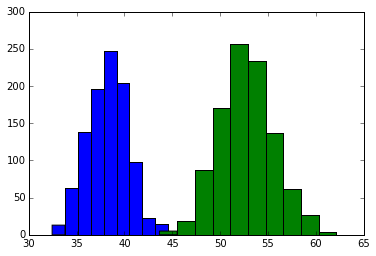

In [18]:
G = 6.674e-8
c = 3.0e10
Msun = 1.989e33

num = 1000

M1 = normal(0.702, 0.022, num)
T1 = normal(14270.0, 270.0, num)
M2 = normal(0.837, 0.022, num)
T2 = normal(18830.0, 220.0, num)

R1 = np.zeros(num)
R2 = np.zeros(num)
v_grav1 = np.zeros(num)
v_grav2 = np.zeros(num)

for i in np.arange(num):
    WDA_r_grid[0] = interp_M04(T1[i])
    WDA_r_grid[1] = interp_M05(T1[i])
    WDA_r_grid[2] = interp_M06(T1[i])
    WDA_r_grid[3] = interp_M07(T1[i])
    WDA_r_grid[4] = interp_M08(T1[i])
    WDA_r_grid[5] = interp_M09(T1[i])
    WDA_r_grid[6] = interp_M10(T1[i])
    interp_WDA = interp1d(WDA_m_grid, WDA_r_grid)
    R1[i] = interp_WDA(M1[i])
    v_grav1[i] = G * M1[i] * Msun / (R1[i] * c) / 1.0e5
    
    
    WDB_r_grid[0] = interp_M04(T2[i])
    WDB_r_grid[1] = interp_M05(T2[i])
    WDB_r_grid[2] = interp_M06(T2[i])
    WDB_r_grid[3] = interp_M07(T2[i])
    WDB_r_grid[4] = interp_M08(T2[i])
    WDB_r_grid[5] = interp_M09(T2[i])
    WDB_r_grid[6] = interp_M10(T2[i])
    interp_WDB = interp1d(WDB_m_grid, WDB_r_grid)
    R2[i] = interp_WDB(M2[i])
    v_grav2[i] = G * M2[i] * Msun / (R2[i] * c) / 1.0e5


plt.hist(v_grav1)
plt.hist(v_grav2)

In [19]:
G = 6.674e-8
c = 3.0e10
Msun = 1.989e33
R_wd_A = interp_WDA(0.702)
R_wd_B = interp_WDB(0.837)

v_grav_A = G * M_wd_A * Msun / (R_wd_A * c)
v_grav_B = G * M_wd_B * Msun / (R_wd_B * c)

print "WD A gravitational redshift:", v_grav_A / 1.0e5, "km/s"
print "WD B gravitational redshift:", v_grav_B / 1.0e5, "km/s"

WD A gravitational redshift: 38.3523839818 km/s
WD B gravitational redshift: 52.5726067002 km/s


In [20]:
v_grav1 = np.sort(v_grav1)
print int(100.0*np.mean(v_grav1))/100.0, -int(100.0*(v_grav1[int(0.158*num)] - np.mean(v_grav1)))/100.0, -int(100.0*(np.mean(v_grav1) - v_grav1[int(0.842*num)]))/100.0

v_grav2 = np.sort(v_grav2)
print int(100.0*np.mean(v_grav2))/100.0, -int(100.0*(v_grav2[int(0.158*num)] - np.mean(v_grav2)))/100.0, -int(100.0*(np.mean(v_grav2) - v_grav2[int(0.842*num)]))/100.0

38.26 2.29 2.09
52.71 2.92 2.85
